<a href="https://colab.research.google.com/github/bhadreshpsavani/UnderstandingNLP/blob/master/UnifiedQA_Inference_QUAIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UnifiedQA Performance on QUAIL Dataset:
We want to check the performance of UnifiedQA base model on QUAIL. QUAIL Dataset is having total 10 different type of questions. 

Here are the Steps we will perform in the notebook,
1. We will analyse QUAIL Dataset
2. Do Preprocessing According to UnifiedQA Input Requirement
3. Perform Inference on UnifiedQA
4. Evaluate the Performance 

## Imports

In [54]:
!pip install -q transformers==3.1.0
!pip install -q datasets

In [171]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelWithLMHead, T5ForConditionalGeneration
from tqdm.notebook import tqdm
tqdm.pandas()

In [172]:
import transformers
transformers.__version__

'3.1.0'

In [131]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

## Task1. Dataset Analysis

### 1. Dataset

In [132]:
dataset = load_dataset("quail")

Reusing dataset quail (/root/.cache/huggingface/datasets/quail/quail/1.3.0/17ee3da60d3c4939a1679994e241f120c7c007baee8cbfb226baf6e106095101)


In [133]:
train_dataset = dataset['train']
validation_dataset = dataset['validation']
challenge_dataset = dataset['challenge']

In [134]:
print("Train", train_dataset)
print("Valid", validation_dataset)
print("Challenge", challenge_dataset)

Train Dataset({
    features: ['id', 'context_id', 'question_id', 'domain', 'metadata', 'context', 'question', 'question_type', 'answers', 'correct_answer_id'],
    num_rows: 10246
})
Valid Dataset({
    features: ['id', 'context_id', 'question_id', 'domain', 'metadata', 'context', 'question', 'question_type', 'answers', 'correct_answer_id'],
    num_rows: 2164
})
Challenge Dataset({
    features: ['id', 'context_id', 'question_id', 'domain', 'metadata', 'context', 'question', 'question_type', 'answers', 'correct_answer_id'],
    num_rows: 556
})


In [135]:
train_dataset[0]

{'answers': ['not enough information',
  'to visit family',
  'parents had problems',
  'for tutoring'],
 'context': "That fall came and I went back to Michigan and the school year went by and summer came and I never really thought about it. I'm not even sure if I was officially asked, I just wound up heading back to New Jersey when school was out. I think my parents thought it was a good enough deal. They were already having some problems and without Nonna there anymore to take care of me I think my cousin's house on the coast seemed like as good a spot as any to stick me for the summer. It certainly wasn't because of any great love between me and my cousin. We weren't really very good friends at that point. I think she saw me as sort of foisted off on her and getting in the way of her summers. Which was a fair enough judgment. But she could have been nicer. It's pretty amazing that she wound up as my Maid of Honor. Time does strange things. Your lovable jack-ass of a father would men

In [136]:
# Process the dataset - add a column with the length of the context texts
train_dataset = train_dataset.map(lambda x: {"context_length": len(x["context"].split())})
train_dataset = train_dataset.map(lambda x: {"question_length": len(x["question"].split())})
train_dataset = train_dataset.map(lambda x: {"number_of_answer": len(x["answers"])})

Loading cached processed dataset at /root/.cache/huggingface/datasets/quail/quail/1.3.0/17ee3da60d3c4939a1679994e241f120c7c007baee8cbfb226baf6e106095101/cache-74c43f36c1c4b703.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/quail/quail/1.3.0/17ee3da60d3c4939a1679994e241f120c7c007baee8cbfb226baf6e106095101/cache-f3319e3bd92e0fad.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/quail/quail/1.3.0/17ee3da60d3c4939a1679994e241f120c7c007baee8cbfb226baf6e106095101/cache-aa0e8f8d0b918dc5.arrow


In [137]:
import pandas as pd
df = pd.DataFrame()

In [138]:
context_length = [train_dataset[i]['context_length'] for i in range(len(train_dataset))]
number_of_answer = [train_dataset[i]['number_of_answer'] for i in range(len(train_dataset))]
question_length = [train_dataset[i]['question_length'] for i in range(len(train_dataset))]
question_type = [train_dataset[i]['question_type'] for i in range(len(train_dataset))]
domain_type = [train_dataset[i]['domain'] for i in range(len(train_dataset))]
df['context_length']=context_length
df['number_of_answer']=number_of_answer
df['question_length']=question_length
df['domain_type']=domain_type
df['question_type']=question_type

### 2. Check the number of answers

In [139]:
df.number_of_answer.value_counts()

4    10246
Name: number_of_answer, dtype: int64

### 3. Check Number of words in the context

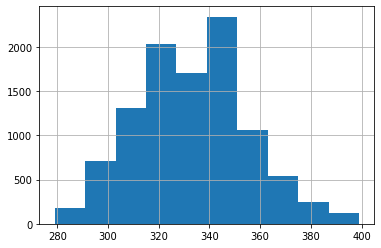

In [140]:
df.context_length.hist()

### 4. Check Number of words in the answer

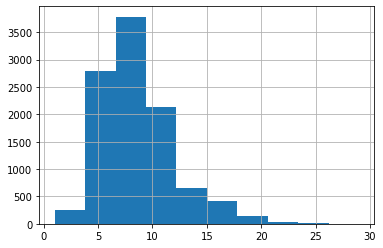

In [141]:
df.question_length.hist()

In [142]:
df.question_length.value_counts()

7     1438
8     1246
6     1161
9     1098
5      961
10     951
11     692
4      672
12     498
13     374
14     276
3      231
15     181
16     121
17     114
18      60
19      59
20      30
2       20
21      20
22      15
23       7
24       6
25       5
1        3
26       2
29       2
27       2
28       1
Name: question_length, dtype: int64

### 5. Different Types of Questions Available 

In [143]:
df.question_type.value_counts()

Factual               1185
Unanswerable          1151
Character_identity    1137
Entity_properties     1137
Causality             1135
Temporal_order        1131
Event_duration        1124
Subsequent_state      1124
Belief_states         1122
Name: question_type, dtype: int64

### 6. Different Type of Domain Available

In [144]:
df.domain_type.value_counts()

fiction         2686
blogs           2520
user_stories    2520
news            2520
Name: domain_type, dtype: int64

## Task1 Observations: 
* Number of words in the question is in range (2, 27) mostly and context is having up to 400 words. We might not need to use sliding window here inorder to get resonable performance
* The Dataset is having `3 one word question` and `20 two word question`, that might seems a bit weird.
* We have four choices of answers
* Our Dataset is having `Four Domain` and `9 Type of Questions` and the distribution of all this type is fairly even

## Task2. Dataset Preprocessing
### 1. Model and Tokenizer

In [198]:
from transformers import AutoTokenizer, AutoModelWithLMHead
model_name = "allenai/unifiedqa-t5-large" # you can specify the model size here
tokenizer = AutoTokenizer.from_pretrained(model_name)
model =  AutoModelWithLMHead.from_pretrained(model_name)

/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:821: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [199]:
def run_model(input_string, **generator_args):
  input_dict = tokenizer(input_string, max_length=512,  truncation=True, return_tensors="pt")
  input_ids = input_dict['input_ids'].to(device)
  attention_mask = input_dict['attention_mask'].to(device)
  res = model.generate(input_ids=input_ids, attention_mask=attention_mask, **generator_args)
  return [tokenizer.decode(x) for x in res]

In [200]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (

### 2. Data Preprocessing

out dataset is like MCTest (Multiple-choice QA) used for training of UnifiedQA
We need to pass the data in `question \n (A) Choice (B) Choice \n context ` according to the [Unified Github](https://github.com/allenai/unifiedqa)

In [201]:
def input_target_creator(dataset):
  inputs_features = []
  target = []
  for i in range(len(dataset)):
    question =  dataset[i]['question']
    answers = dataset[i]['answers']
    context = dataset[i]['context']
    correct_answer = dataset[i]['answers'][dataset[i]['correct_answer_id']-1]
    target.append(correct_answer)
    input = question + " \\n" + " (A) " + answers[0] + " (B) " + answers[1] + " (C) " + answers[2] + " (D) " + answers[3]  + " \\n "  + context
    inputs_features.append(input)
  return inputs_features, target

In [202]:
inputs_features, target = input_target_creator(validation_dataset)

In [203]:
new_df = pd.DataFrame()
new_df['input_features'] = inputs_features
new_df['target'] = target

In [204]:
new_df['feature_length'] = new_df['input_features'].apply(lambda input: len(tokenizer.tokenize(input)))

In [205]:
# remove data with more than 512 length
new_df = new_df.query('feature_length<=512')

In [215]:
new_df['prediction'] = new_df['input_features'].progress_apply(run_model)

In [216]:
"""Evaluation utilities."""
import argparse
import collections
import json
import os
import re
import string
import sys
import numpy as np

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))


def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()


def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))


def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def make_eval_dict(exact_scores, f1_scores):
    total = len(exact_scores)
    return collections.OrderedDict([("exact", 100.0 * sum(exact_scores.values / total)), ("f1", 100.0 * sum(f1_scores.values / total)),("total", total)])

In [217]:
new_df['new_prediction'] = new_df['prediction'].apply(lambda predi : predi[0])

In [218]:
new_df.head()

,input_features,target,feature_length,prediction,exact_match,f1_score,new_prediction
0,How long was Candy trying to seduce Larry? \n ...,All day,481,[about 2 hours],0,0.0,about 2 hours
1,What is probably true about Larry. \n (A) Larr...,not enough information,499,[not enough information],1,1.0,not enough information
2,What was Larry impressed with? \n (A) How wind...,not enough information,484,[That Candy had all her teeth],0,0.0,That Candy had all her teeth
3,Why did Candy press her legs together. \n (A) ...,To warm her butt.,486,[because she was cold],0,0.0,because she was cold
4,Who thought prostitutes were revolting? \n (A)...,not enough information,479,[Larry],0,0.0,Larry


In [220]:
new_df['exact_match'] = new_df.apply(lambda row:compute_exact(row['target'], row['new_prediction']), axis=1)
new_df['f1_score'] = new_df.apply(lambda row:compute_f1(row['target'], row['new_prediction']), axis=1)
make_eval_dict(new_df['exact_match'], new_df['f1_score'])

OrderedDict([('exact', 12.460815047021967),
             ('f1', 22.75461298340418),
             ('total', 1276)])

UnifiefQA_Small:
```
OrderedDict([('exact', 21.63009404388722),
             ('f1', 27.687265700335846),
             ('total', 1276)])
```

UnifiedQA_Base:
```
OrderedDict([('exact', 14.576802507837025),
             ('f1', 23.737297181234666),
             ('total', 1276)])
```

UnifiedQA-Large:
```
OrderedDict([('exact', 12.460815047021967),
             ('f1', 22.75461298340418),
             ('total', 1276)])
```